In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, mutual_info_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# Load the dataset
df = pd.read_csv('dataset.csv')

# Initial exploration
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
display(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isna().sum())

# Data types
print("\nData types:")
print(df.dtypes)

# Summary statistics
print("\nSummary statistics:")
display(df.describe())

Dataset shape: (2766, 20)

First few rows:


,STN Code,Name of Monitoring Location,Type Water Body,State Name,Min Temperature,Max Temperature,Min Dissolved Oxygen,Max Dissolved Oxygen,Min pH,Max pH,Min Conductivity,Max Conductivity,Min BOD,Max BOD,Min Nitrate N + Nitrite N,Max Nitrate N + Nitrite N,Min Fecal Coliform,Max Fecal Coliform,Min Total Coliform,Max Total Coliform
0,5159.0,"GARGEYAPURAM LAKE GARGEYAPURAM (V), KURNOOL (M)",LAKE,ANDHRA PRADESH,22,27,3.9,6.5,7.1,7.9,374,1370,1.5,3.7,0.33,5.90,214,525,816,1733
1,4368.0,"KOLLERU LAKE, KOKKIRAYALANKA (V), KAILALUR (M)",LAKE,ANDHRA PRADESH,18,29,3.2,8.7,7.2,8.6,215,1800,1.6,6.1,0.69,2.79,7,21,210,460
2,2353.0,"KONDAKARLA-AAVA LAKE, KONDAKARLA, VISHAKHAPA...",LAKE,ANDHRA PRADESH,26,29,3.4,6.4,7.1,8.5,402,888,2.4,4.8,1.12,2.42,7,39,150,240
3,5147.0,"PALASAMUDRAM LAKE, PALASAMUDRAM (V), PENUKON...",LAKE,ANDHRA PRADESH,23,27,5.1,6.1,6.6,7.8,322,535,1.5,2.2,0.32,1.26,89,388,491,1046
4,1790.0,"PULICATE LAKE, SRIHARI KOTA, SULLURUPETA (M)",LAKE,ANDHRA PRADESH,18,22,5.7,6.8,7.4,8.1,31100,42200,2.6,2.9,1.11,1.78,3,62,75,689



Missing values:
STN Code                        40
Name of Monitoring Location     28
Type Water Body                 39
State Name                      39
Min Temperature                 27
Max Temperature                 28
Min Dissolved Oxygen            16
Max Dissolved Oxygen            16
Min pH                          14
Max pH                          14
Min Conductivity                27
Max Conductivity                27
Min BOD                         21
Max BOD                         21
Min Nitrate N + Nitrite N       72
Max Nitrate N + Nitrite N       72
Min Fecal Coliform             117
Max Fecal Coliform             117
Min Total Coliform              98
Max Total Coliform              98
dtype: int64

Data types:
STN Code                       float64
Name of Monitoring Location     object
Type Water Body                 object
State Name                      object
Min Temperature                 object
Max Temperature                 object
Min Dissolved Oxygen   

,STN Code
count,2726.000000
mean,3321.133529
std,1050.801206
min,1215.000000
25%,2432.000000
50%,3588.000000
75%,4192.000000
max,5291.000000


In [2]:
# Function to clean the data
def clean_data(df):
    # Create a copy to avoid modifying the original
    cleaned_df = df.copy()
    
    # Drop rows with STN Code as NaN (if any)
    cleaned_df = cleaned_df.dropna(subset=['STN Code'])
    
    # Convert numeric columns from object to float if needed
    numeric_cols = [col for col in df.columns if any(x in col for x in 
                   ['Temperature', 'Dissolved Oxygen', 'pH', 'Conductivity', 
                    'BOD', 'Nitrate', 'Fecal Coliform', 'Total Coliform'])]
    
    for col in numeric_cols:
        cleaned_df[col] = pd.to_numeric(cleaned_df[col], errors='coerce')
    
    # Fill missing values with median for numeric columns
    for col in numeric_cols:
        cleaned_df[col] = cleaned_df[col].fillna(cleaned_df[col].median())
    
    # Remove any rows that still have NaN in critical columns
    cleaned_df = cleaned_df.dropna(subset=numeric_cols)
    
    # Create range features (difference between min and max)
    cleaned_df['Temperature_Range'] = cleaned_df['Max Temperature'] - cleaned_df['Min Temperature']
    cleaned_df['DO_Range'] = cleaned_df['Max Dissolved Oxygen'] - cleaned_df['Min Dissolved Oxygen']
    cleaned_df['pH_Range'] = cleaned_df['Max pH'] - cleaned_df['Min pH']
    cleaned_df['Conductivity_Range'] = cleaned_df['Max Conductivity'] - cleaned_df['Min Conductivity']
    
    # Create water body type categorical encoding
    cleaned_df['Type_LAKE'] = (cleaned_df['Type Water Body'] == 'LAKE').astype(int)
    cleaned_df['Type_TANK'] = (cleaned_df['Type Water Body'] == 'TANK').astype(int)
    cleaned_df['Type_WETLAND'] = (cleaned_df['Type Water Body'] == 'WETLAND').astype(int)
    
    return cleaned_df

# Apply cleaning
cleaned_df = clean_data(df)
print(f"Cleaned dataset shape: {cleaned_df.shape}")
display(cleaned_df.head())

Cleaned dataset shape: (2726, 27)


,STN Code,Name of Monitoring Location,Type Water Body,State Name,Min Temperature,Max Temperature,Min Dissolved Oxygen,Max Dissolved Oxygen,Min pH,Max pH,...,Max Fecal Coliform,Min Total Coliform,Max Total Coliform,Temperature_Range,DO_Range,pH_Range,Conductivity_Range,Type_LAKE,Type_TANK,Type_WETLAND
0,5159.0,"GARGEYAPURAM LAKE GARGEYAPURAM (V), KURNOOL (M)",LAKE,ANDHRA PRADESH,22.0,27.0,3.9,6.5,7.1,7.9,...,525.0,816.0,1733.0,5.0,2.6,0.8,996.0,1,0,0
1,4368.0,"KOLLERU LAKE, KOKKIRAYALANKA (V), KAILALUR (M)",LAKE,ANDHRA PRADESH,18.0,29.0,3.2,8.7,7.2,8.6,...,21.0,210.0,460.0,11.0,5.5,1.4,1585.0,1,0,0
2,2353.0,"KONDAKARLA-AAVA LAKE, KONDAKARLA, VISHAKHAPA...",LAKE,ANDHRA PRADESH,26.0,29.0,3.4,6.4,7.1,8.5,...,39.0,150.0,240.0,3.0,3.0,1.4,486.0,1,0,0
3,5147.0,"PALASAMUDRAM LAKE, PALASAMUDRAM (V), PENUKON...",LAKE,ANDHRA PRADESH,23.0,27.0,5.1,6.1,6.6,7.8,...,388.0,491.0,1046.0,4.0,1.0,1.2,213.0,1,0,0
4,1790.0,"PULICATE LAKE, SRIHARI KOTA, SULLURUPETA (M)",LAKE,ANDHRA PRADESH,18.0,22.0,5.7,6.8,7.4,8.1,...,62.0,75.0,689.0,4.0,1.1,0.7,11100.0,1,0,0


Selected features: ['Min Temperature', 'Max Temperature', 'Min Dissolved Oxygen', 'Max Dissolved Oxygen', 'Min pH', 'Max pH', 'Min Conductivity', 'Max Conductivity', 'Min BOD', 'Max BOD', 'Min Nitrate N + Nitrite N', 'Max Nitrate N + Nitrite N', 'Min Fecal Coliform', 'Max Fecal Coliform', 'Min Total Coliform', 'Max Total Coliform', 'Temperature_Range', 'DO_Range', 'pH_Range', 'Conductivity_Range', 'Type_LAKE', 'Type_TANK', 'Type_WETLAND']
Feature matrix shape: (2726, 23)


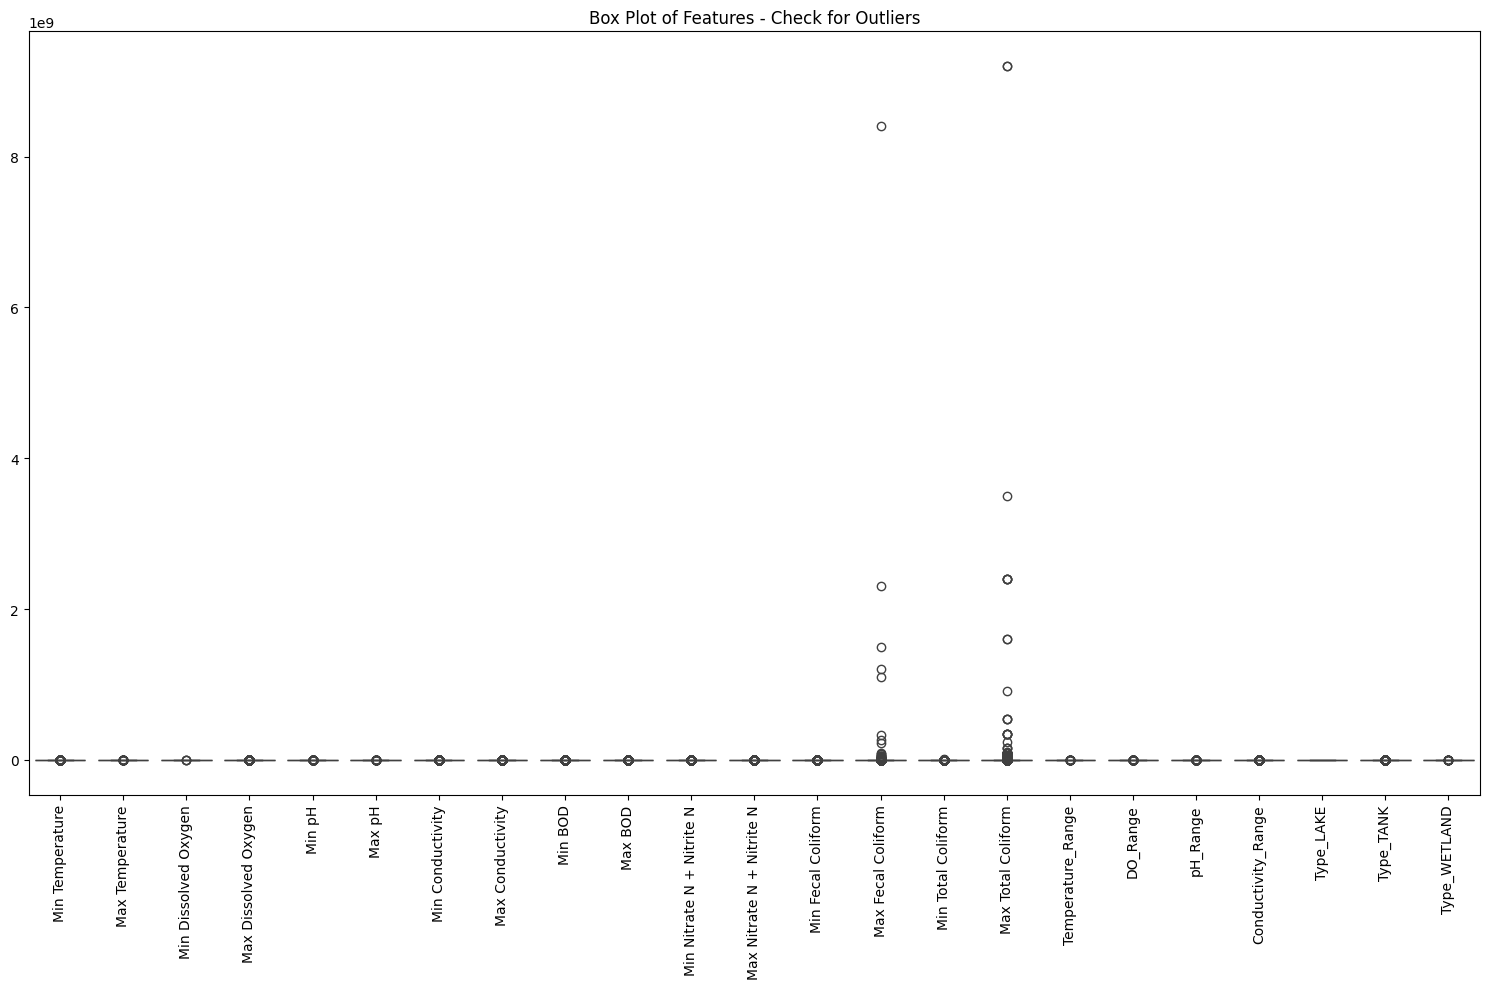

Data after standardization (first 5 rows):


,Min Temperature,Max Temperature,Min Dissolved Oxygen,Max Dissolved Oxygen,Min pH,Max pH,Min Conductivity,Max Conductivity,Min BOD,Max BOD,...,Max Fecal Coliform,Min Total Coliform,Max Total Coliform,Temperature_Range,DO_Range,pH_Range,Conductivity_Range,Type_LAKE,Type_TANK,Type_WETLAND
0,0.111310,-0.532903,-0.006280,-0.181600,0.164476,-0.326185,-0.218658,0.345893,-0.679232,-0.650808,...,-0.541243,-0.191834,-0.537552,-0.475329,-0.133014,-0.477066,0.795786,0.826266,0.0,0.0
1,-0.767503,0.006470,-0.306256,0.933072,0.375116,1.027945,-0.638200,0.824344,-0.624681,-0.438976,...,-0.659970,-0.609431,-0.638670,0.619977,1.272684,0.737097,1.851524,0.826266,0.0,0.0
2,0.990124,0.006470,-0.220549,-0.232267,0.164476,0.834498,-0.144776,-0.190417,-0.188273,-0.553718,...,-0.655729,-0.650777,-0.656145,-0.840432,0.060875,0.737097,-0.118351,0.826266,0.0,0.0
3,0.331014,-0.532903,0.507964,-0.384267,-0.888727,-0.519632,-0.355867,-0.583191,-0.679232,-0.783202,...,-0.573516,-0.415793,-0.592122,-0.657880,-0.908572,0.332376,-0.607683,0.826266,0.0,0.0
4,-0.767503,-1.881337,0.765087,-0.029599,0.796398,0.060709,2.435805,2.487237,-0.079171,-0.721418,...,-0.650311,-0.702460,-0.620479,-0.657880,-0.860100,-0.679426,2.320915,0.826266,0.0,0.0


In [3]:
# Select only numeric features for clustering
numeric_features = [col for col in cleaned_df.columns if 
                   cleaned_df[col].dtype in ['int64', 'float64'] and 
                   col not in ['STN Code']]

# Create a DataFrame with only numeric features
X = cleaned_df[numeric_features].copy()

print(f"Selected features: {X.columns.tolist()}")
print(f"Feature matrix shape: {X.shape}")

# Check for outliers using box plots
plt.figure(figsize=(15, 10))
sns.boxplot(data=X)
plt.xticks(rotation=90)
plt.title('Box Plot of Features - Check for Outliers')
plt.tight_layout()
plt.show()

# Handle outliers using capping
def cap_outliers(df):
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    return df

# Cap outliers
X = cap_outliers(X)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("Data after standardization (first 5 rows):")
display(X_scaled_df.head())

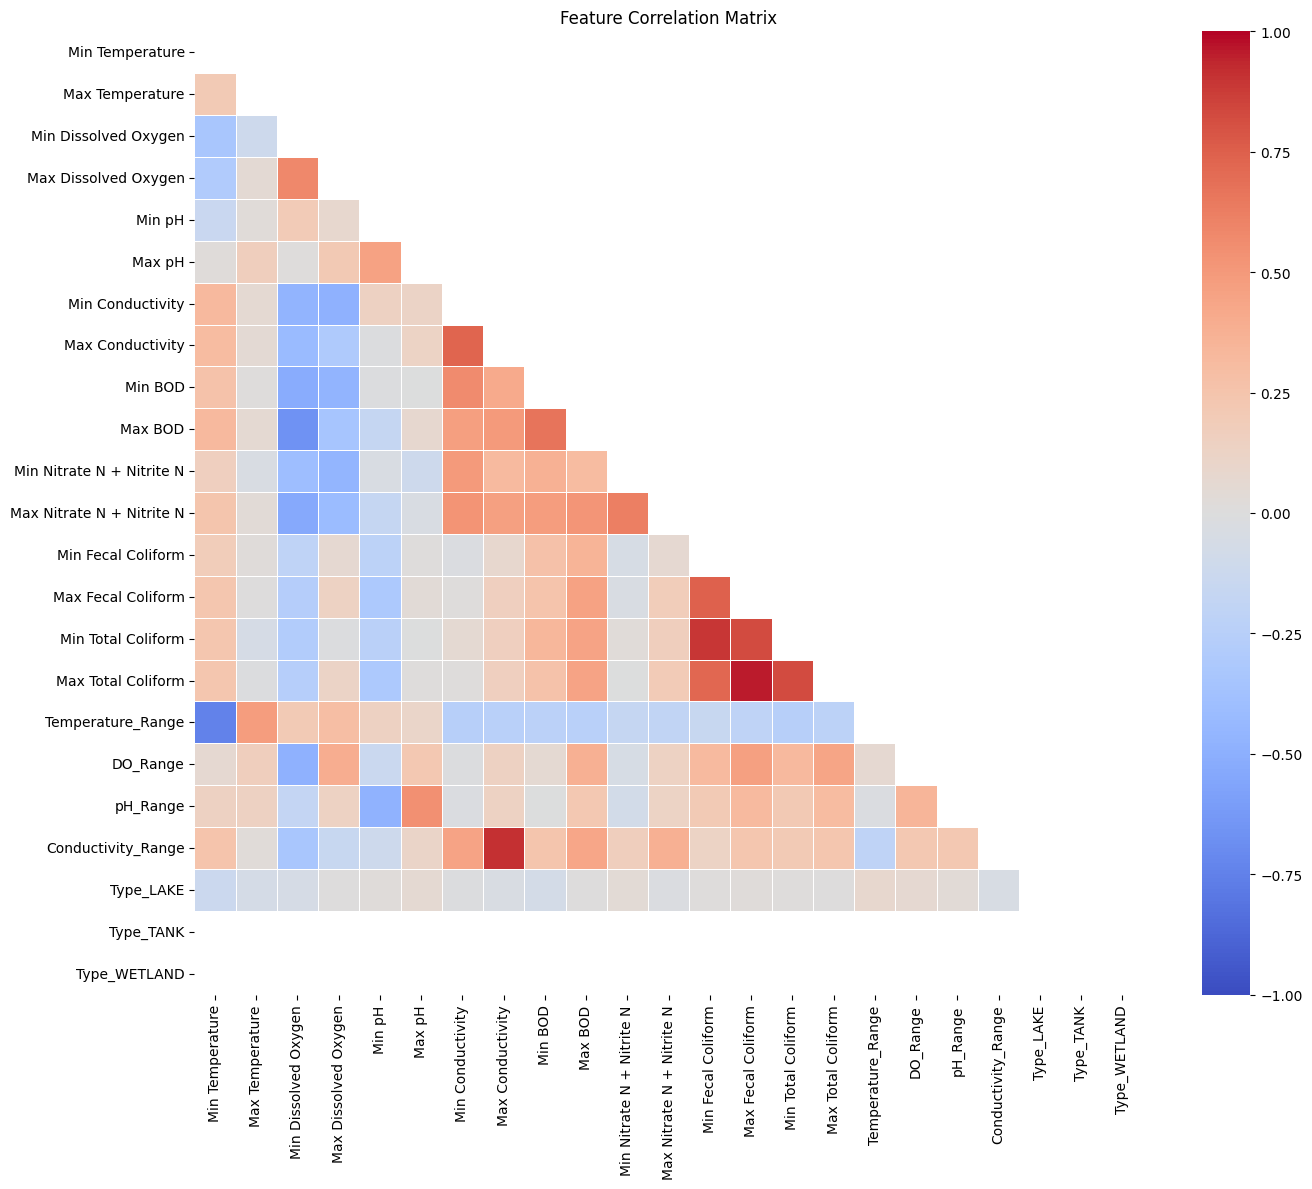

Features to drop due to high correlation: ['Min Total Coliform', 'Conductivity_Range', 'Max Total Coliform']
Features remaining after correlation filtering: ['Min Temperature', 'Max Temperature', 'Min Dissolved Oxygen', 'Max Dissolved Oxygen', 'Min pH', 'Max pH', 'Min Conductivity', 'Max Conductivity', 'Min BOD', 'Max BOD', 'Min Nitrate N + Nitrite N', 'Max Nitrate N + Nitrite N', 'Min Fecal Coliform', 'Max Fecal Coliform', 'Temperature_Range', 'DO_Range', 'pH_Range', 'Type_LAKE', 'Type_TANK', 'Type_WETLAND']


In [4]:
# Correlation analysis
plt.figure(figsize=(14, 12))
correlation_matrix = X.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', 
            vmin=-1, vmax=1, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Function to filter highly correlated features
def filter_correlated_features(correlation_matrix, threshold=0.8):
    features_to_drop = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                features_to_drop.append(correlation_matrix.columns[j])
    return list(set(features_to_drop))

correlated_features = filter_correlated_features(correlation_matrix, threshold=0.8)
print(f"Features to drop due to high correlation: {correlated_features}")

# Create a correlation-filtered dataset
X_corr_filtered = X.drop(columns=correlated_features)
print(f"Features remaining after correlation filtering: {X_corr_filtered.columns.tolist()}")

In [5]:
# Use random forest as the base estimator for RFE
# We'll use a target-free approach since this is clustering
def apply_rfe(X, n_features_to_select=10):
    # Create a synthetic target for demonstration (using the first feature)
    y = X.iloc[:, 0]
    
    # Create the RFE model
    estimator = RandomForestRegressor(random_state=42)
    selector = RFE(estimator, n_features_to_select=n_features_to_select, step=1)
    selector = selector.fit(X, y)
    
    # Get the selected features
    selected_features = [feature for feature, selected in 
                         zip(X.columns, selector.support_) if selected]
    
    # Get feature ranking (lower = more important)
    feature_ranking = pd.DataFrame({
        'Feature': X.columns,
        'Ranking': selector.ranking_
    }).sort_values('Ranking')
    
    return selected_features, feature_ranking

# Apply RFE
rfe_selected, rfe_ranking = apply_rfe(X, n_features_to_select=min(10, X.shape[1]))

print("RFE Feature Ranking:")
display(rfe_ranking)
print(f"\nRFE Selected Features: {rfe_selected}")

RFE Feature Ranking:


,Feature,Ranking
0,Min Temperature,1
1,Max Temperature,1
2,Min Dissolved Oxygen,1
19,Conductivity_Range,1
4,Min pH,1
8,Min BOD,1
9,Max BOD,1
10,Min Nitrate N + Nitrite N,1
15,Max Total Coliform,1
13,Max Fecal Coliform,1



RFE Selected Features: ['Min Temperature', 'Max Temperature', 'Min Dissolved Oxygen', 'Min pH', 'Min BOD', 'Max BOD', 'Min Nitrate N + Nitrite N', 'Max Fecal Coliform', 'Max Total Coliform', 'Conductivity_Range']


In [6]:
# Calculate mutual information for each feature
def mutual_info_selection(X, n_features_to_select=10):
    # Create a synthetic target for demonstration
    y = X.iloc[:, 0]
    
    # Calculate mutual information
    mutual_info = mutual_info_regression(X, y)
    
    # Create a dataframe of features and their mutual information scores
    mi_df = pd.DataFrame({
        'Feature': X.columns,
        'Mutual_Information': mutual_info
    }).sort_values('Mutual_Information', ascending=False)
    
    # Select top features
    selected_features = mi_df.head(n_features_to_select)['Feature'].tolist()
    
    return selected_features, mi_df

# Apply mutual information
mi_selected, mi_df = mutual_info_selection(X, n_features_to_select=min(10, X.shape[1]))

print("Mutual Information Feature Ranking:")
display(mi_df)
print(f"\nMutual Information Selected Features: {mi_selected}")

Mutual Information Feature Ranking:


,Feature,Mutual_Information
0,Min Temperature,2.831981
16,Temperature_Range,0.559797
13,Max Fecal Coliform,0.256006
15,Max Total Coliform,0.250768
1,Max Temperature,0.248755
12,Min Fecal Coliform,0.244945
11,Max Nitrate N + Nitrite N,0.238972
14,Min Total Coliform,0.226719
9,Max BOD,0.200316
8,Min BOD,0.189779



Mutual Information Selected Features: ['Min Temperature', 'Temperature_Range', 'Max Fecal Coliform', 'Max Total Coliform', 'Max Temperature', 'Min Fecal Coliform', 'Max Nitrate N + Nitrite N', 'Min Total Coliform', 'Max BOD', 'Min BOD']


Feature selection votes:
Max BOD: 3 vote(s)
Min Temperature: 3 vote(s)
Min BOD: 3 vote(s)
Max Temperature: 3 vote(s)
Max Fecal Coliform: 3 vote(s)
Min Dissolved Oxygen: 2 vote(s)
Min Nitrate N + Nitrite N: 2 vote(s)
Max Nitrate N + Nitrite N: 2 vote(s)
Max Total Coliform: 2 vote(s)
Min pH: 2 vote(s)
Temperature_Range: 2 vote(s)
Min Fecal Coliform: 2 vote(s)
Type_WETLAND: 1 vote(s)
pH_Range: 1 vote(s)
Min Total Coliform: 1 vote(s)
Max Dissolved Oxygen: 1 vote(s)
Type_LAKE: 1 vote(s)
DO_Range: 1 vote(s)
Max pH: 1 vote(s)
Min Conductivity: 1 vote(s)
Type_TANK: 1 vote(s)
Max Conductivity: 1 vote(s)
Conductivity_Range: 1 vote(s)

Consensus features (selected by ≥2 methods): ['Max BOD', 'Min Temperature', 'Min BOD', 'Max Temperature', 'Max Fecal Coliform', 'Min Dissolved Oxygen', 'Min Nitrate N + Nitrite N', 'Max Nitrate N + Nitrite N', 'Max Total Coliform', 'Min pH', 'Temperature_Range', 'Min Fecal Coliform']


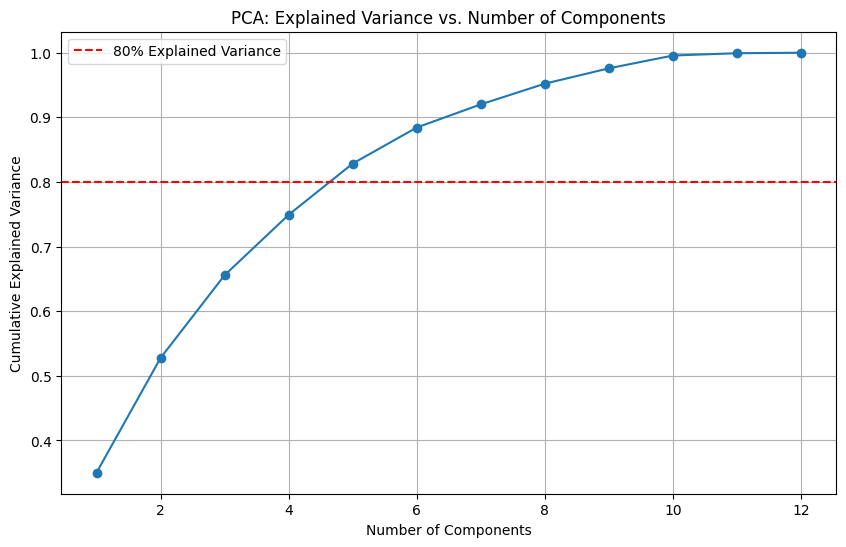

Optimal number of components: 5 (explains 82.85% of variance)
PCA result shape: (2726, 5)
PCA results saved to 'pca.csv'


In [7]:
# Combine the results of all feature selection methods
def get_combined_features(corr_filtered, rfe_selected, mi_selected):
    # Count how many methods selected each feature
    all_features = list(set(corr_filtered.columns) | set(rfe_selected) | set(mi_selected))
    feature_votes = {}
    
    for feature in all_features:
        votes = 0
        if feature in corr_filtered.columns:
            votes += 1
        if feature in rfe_selected:
            votes += 1
        if feature in mi_selected:
            votes += 1
        feature_votes[feature] = votes
    
    # Sort by votes (highest first)
    sorted_features = sorted(feature_votes.items(), key=lambda x: x[1], reverse=True)
    
    # Features selected by at least 2 methods
    consensus_features = [feature for feature, votes in sorted_features if votes >= 2]
    return consensus_features, sorted_features

consensus_features, feature_votes = get_combined_features(X_corr_filtered, rfe_selected, mi_selected)

print("Feature selection votes:")
for feature, votes in feature_votes:
    print(f"{feature}: {votes} vote(s)")

print(f"\nConsensus features (selected by ≥2 methods): {consensus_features}")

# If we have too few consensus features, use all features selected by at least one method
if len(consensus_features) < 3:
    consensus_features = [feature for feature, _ in feature_votes]
    print(f"\nUsing all features selected by at least one method: {consensus_features}")

# Apply PCA with the selected features
X_selected = X[consensus_features]
X_selected_scaled = scaler.fit_transform(X_selected)

# Determine optimal number of components
pca = PCA()
pca.fit(X_selected_scaled)

# Plot explained variance
plt.figure(figsize=(10, 6))
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Explained Variance vs. Number of Components')
plt.grid(True)
plt.legend()
plt.show()

# Choose number of components that explain at least 80% of variance
n_components = np.argmax(cumulative_variance >= 0.8) + 1
print(f"Optimal number of components: {n_components} (explains {cumulative_variance[n_components-1]:.2%} of variance)")

# Apply PCA with optimal number of components
pca = PCA(n_components=min(n_components, len(consensus_features)))
X_pca = pca.fit_transform(X_selected_scaled)

# If we have fewer than 2 components, force 2 for visualization
if X_pca.shape[1] < 2:
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_selected_scaled)
    print("Forcing 2 components for visualization purposes")

print(f"PCA result shape: {X_pca.shape}")
# Create a DataFrame with PCA results
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# Add original features used for PCA for reference
for col in consensus_features:
    pca_df[f'orig_{col}'] = X_selected[col].values

# Add any identifier columns if available (like STN Code)
if 'STN Code' in cleaned_df.columns:
    pca_df['STN_Code'] = cleaned_df['STN Code'].values

# Add water body type if available
if 'Type Water Body' in cleaned_df.columns:
    pca_df['Water_Body_Type'] = cleaned_df['Type Water Body'].values

# Save to CSV
pca_df.to_csv('pca.csv', index=False)
print("PCA results saved to 'pca.csv'")

For n_clusters = 2, the silhouette score is 0.329
For n_clusters = 3, the silhouette score is 0.346
For n_clusters = 4, the silhouette score is 0.274
For n_clusters = 5, the silhouette score is 0.272
For n_clusters = 6, the silhouette score is 0.265
For n_clusters = 7, the silhouette score is 0.251
For n_clusters = 8, the silhouette score is 0.233
For n_clusters = 9, the silhouette score is 0.223
For n_clusters = 10, the silhouette score is 0.229


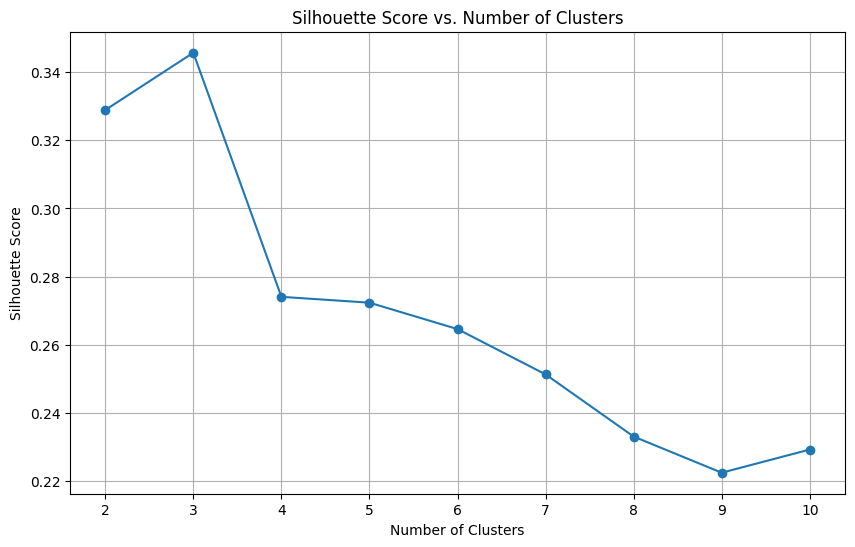

Optimal number of clusters: 3


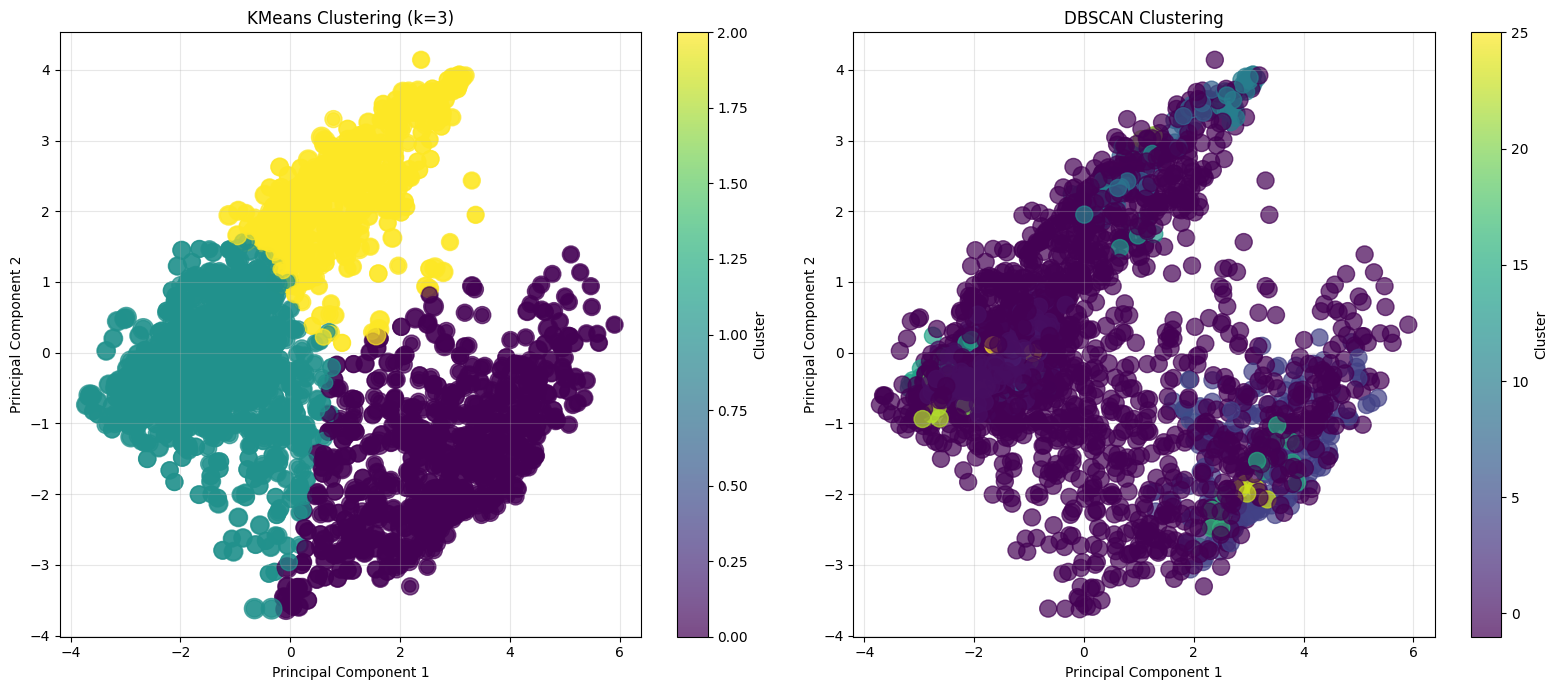

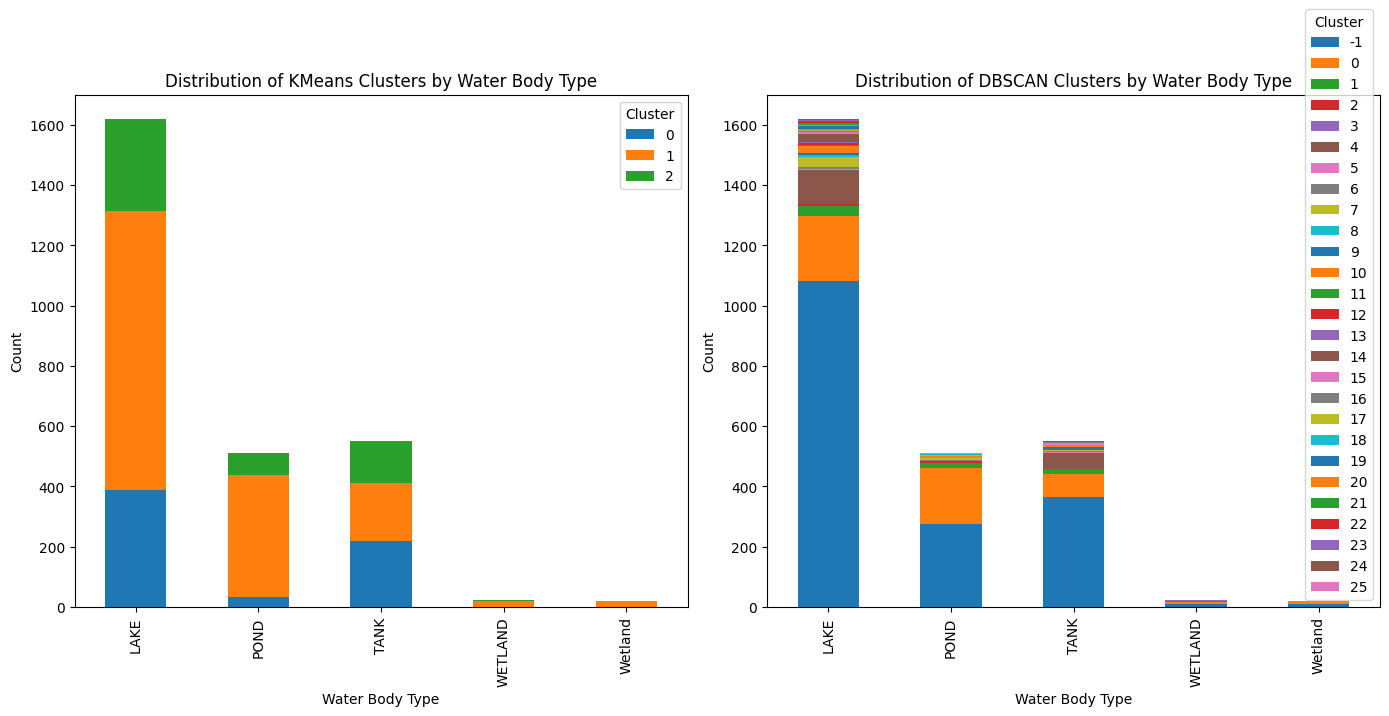


Cluster Profiles (Mean values of features by cluster):


,Max BOD,Min Temperature,Min BOD,Max Temperature,Max Fecal Coliform,Min Dissolved Oxygen,Min Nitrate N + Nitrite N,Max Nitrate N + Nitrite N,Max Total Coliform,Min pH,Temperature_Range,Min Fecal Coliform
KMeans_Cluster,,,,,,,,,,,,
0,34.342672,23.765469,4.969625,28.600000,2.550252e+07,2.546406,0.855687,7.850297,6.583405e+07,6.728750,4.834531,3435.678125
1,4.830682,19.588457,1.811939,28.847895,4.281682e+03,5.234949,0.475026,2.524101,3.558048e+05,7.105066,9.259439,131.507653
2,26.844691,23.460811,7.475676,29.649614,2.186000e+03,1.627606,3.727220,16.392336,1.540703e+03,7.071042,6.188803,62.976834


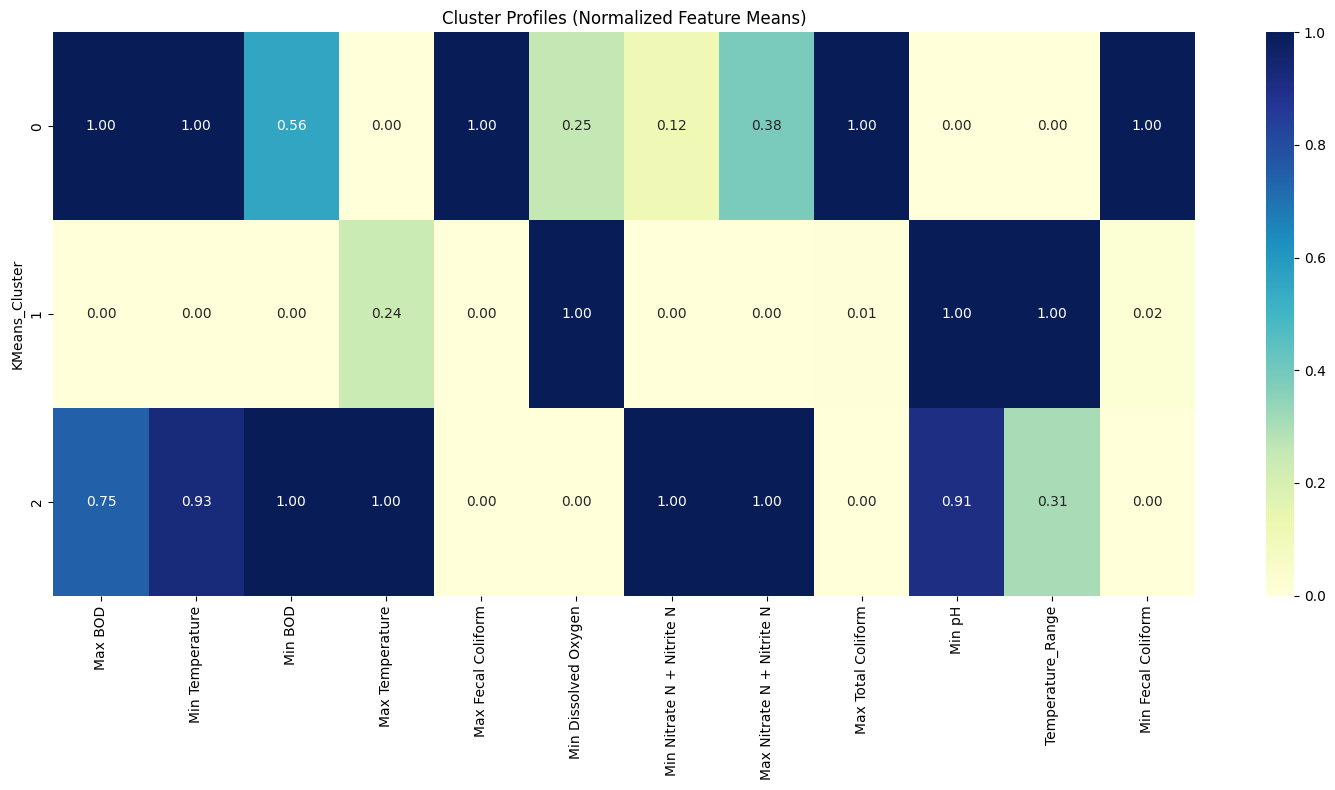

In [8]:
# Find optimal number of clusters using silhouette scores
silhouette_scores = []
range_n_clusters = range(2, min(11, len(X_pca)))
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg:.3f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()

# Choose optimal number of clusters
optimal_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters: {optimal_clusters}")

# Apply KMeans with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

# Also try DBSCAN as an alternative
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca)
# Visualize clusters
plt.figure(figsize=(16, 7))

# KMeans
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7, s=150)
plt.colorbar(scatter, label='Cluster')
if X_pca.shape[1] >= 3:  # Add third dimension as size if available
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', 
                alpha=0.7, s=120+X_pca[:, 2]*30)
plt.title(f'KMeans Clustering (k={optimal_clusters})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, alpha=0.3)

# DBSCAN
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7, s=150)
plt.colorbar(scatter, label='Cluster')
plt.title('DBSCAN Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create a dataframe with the original data, PCA results, and cluster labels
result_df = cleaned_df.copy()
for i in range(X_pca.shape[1]):
    result_df[f'PC{i+1}'] = X_pca[:, i]
result_df['KMeans_Cluster'] = cluster_labels
result_df['DBSCAN_Cluster'] = dbscan_labels

# Show the distribution of clusters across water body types
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
cross_tab_kmeans = pd.crosstab(result_df['Type Water Body'], result_df['KMeans_Cluster'])
cross_tab_kmeans.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Distribution of KMeans Clusters by Water Body Type')
plt.xlabel('Water Body Type')
plt.ylabel('Count')
plt.legend(title='Cluster')

plt.subplot(1, 2, 2)
cross_tab_dbscan = pd.crosstab(result_df['Type Water Body'], result_df['DBSCAN_Cluster'])
cross_tab_dbscan.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Distribution of DBSCAN Clusters by Water Body Type')
plt.xlabel('Water Body Type')
plt.ylabel('Count')
plt.legend(title='Cluster')

plt.tight_layout()
plt.show()

# Profile the clusters
cluster_profiles = result_df.groupby('KMeans_Cluster')[consensus_features].mean()
print("\nCluster Profiles (Mean values of features by cluster):")
display(cluster_profiles)

# Visualize the cluster profiles
plt.figure(figsize=(15, 8))
cluster_profiles_scaled = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())
sns.heatmap(cluster_profiles_scaled, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Cluster Profiles (Normalized Feature Means)')
plt.tight_layout()
plt.show()